# CIFAR analysis

In [ ]:
import pickle


import tensorflow as tf
from tensorflow.python import  keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPool2D
from tensorflow.python.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import sys


import cv2
from skimage.transform import rescale, resize

from sklearn import svm
from sklearn import decomposition
from sklearn.model_selection import train_test_split

In [ ]:
def plot_clasifier_accuracy(train_data, test_data, y_train, Cs):
    Cs = np.arange(0.05, 0.5, 0.05)
    ACCs = np.zeros(len(Cs))
    for idx, C in enumerate(Cs):
        classifier = svm.LinearSVC(C=C)
        classifier.fit(codes_train, y_train)

        predictions = cnn_classifier.predict(codes_test)
        ACCs[idx] = np.mean(cnn_predictions == np.array(y_test))

    plt.plot(Cs, ACCs)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.title('Hyperparameter search')
    plt.grid(True)
    
    argmax = np.argmax(ACCs)
    print("Maximum for C={}".format(Cs[argmax]))
    
    

## Unpickling data

In [147]:
random.seed(17)

with open("../cifar-10-batches-py/data_batch_1","rb") as infile:
    cifar = pickle.load(infile, encoding="bytes")
    
X_train,  X_test, y_train, y_test = train_test_split(cifar[b'data'][:6000],cifar[b'labels'][:6000],test_size=1./6.)

X_train = X_train.reshape(-1,3,32,32).transpose([0,2, 3, 1])
X_test = X_test.reshape(-1,3,32,32).transpose([0,2, 3, 1])

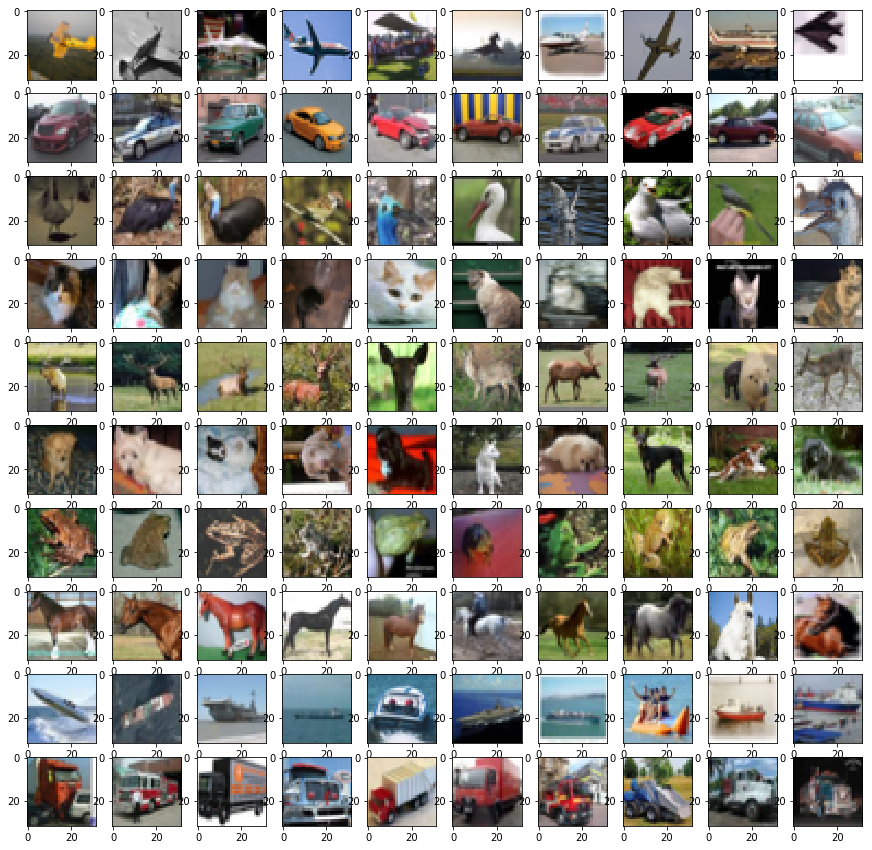

In [129]:
random_indices = []
for idx in range(10):
    random_indices += list(np.random.choice(np.where(np.array(y_train)==idx)[0], size=10))

fig = plt.figure(figsize=(15,15))
for i, ridx in enumerate(random_indices):
    fig.add_subplot(10,10,i+1)

    tmp_picture = X_train[ridx,:]
    plt.imshow(tmp_picture)
    
plt.show()

## Shallow clasifier

In [ ]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [6]:

train_descriptors = np.zeros((X_train.shape[0], 324))

for idx, img in enumerate(X_train):
    descriptor = hog.compute(img)
    train_descriptors[idx,:] = descriptor.ravel()

In [7]:
shallow_classifier = svm.LinearSVC()
shallow_classifier.fit(train_descriptors, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [8]:

test_descriptors = np.zeros((X_test.shape[0], 324))

for idx, img in enumerate(X_test):
    descriptor = hog.compute(img)
    test_descriptors[idx,:] = descriptor.ravel()

In [9]:
shallow_predict = shallow_classifier.predict(test_descriptors)

In [10]:
np.mean(shallow_predict==y_test)

0.507

## Pretrained neural network

#### VGG16

In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')

In [12]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
VGG_MEAN = np.array([124, 117, 104])
VGG_MEAN = VGG_MEAN.reshape(1,1,1,3)

X_train_vgg = np.zeros((X_train.shape[0],224,224,3))
for idx, img in  enumerate(X_train):
    X_train_vgg[idx,...] = resize(img, (224,224), preserve_range=True)
    
X_train_vgg -= VGG_MEAN

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
descriptor_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer('fc2').output)
codes_train= descriptor_model.predict(X_train_vgg)

In [116]:
pca = decomposition.PCA(n_components=4096, whiten=False)
codes_train2 = pca.fit_transform(codes_train)

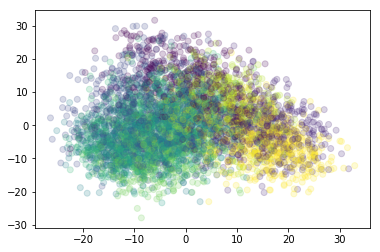

In [118]:
plt.scatter(codes_train2[:,0], codes_train2[:,1], alpha=0.2, c=y_train)

In [148]:
cnn_classifier = svm.LinearSVC(C=0.4)
cnn_classifier.fit(codes_train, y_train)

LinearSVC(C=0.4, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [23]:
X_test_vgg = np.zeros((X_test.shape[0],224,224,3))
for idx, img in  enumerate(X_test):
    X_test_vgg[idx,...] = resize(img, (224,224), preserve_range=True)
    
X_test_vgg -= VGG_MEAN

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [24]:
codes_test = descriptor_model.predict(X_test_vgg)

In [120]:
codes_test2 = pca.transform(codes_test)

In [149]:
cnn_predictions = cnn_classifier.predict(codes_test)

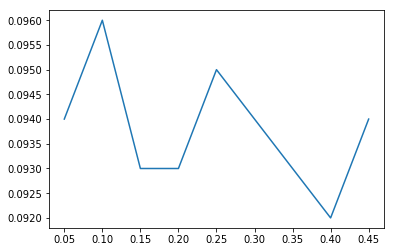

In [145]:
Cs = np.arange(0.05, 0.5, 0.05)
ACCs = np.zeros(len(Cs))
for idx, C in enumerate(Cs):
    cnn_classifier = svm.LinearSVC(C=C)
    cnn_classifier.fit(codes_train, y_train)
    
    cnn_predictions = cnn_classifier.predict(codes_test)
    ACCs[idx] = np.mean(cnn_predictions == np.array(y_test))
    
plt.plot(Cs, ACCs)
    
    

In [146]:
ACCs

array([0.094, 0.096, 0.093, 0.093, 0.095, 0.094, 0.093, 0.092, 0.094])

In [150]:
np.mean(cnn_predictions == np.array(y_test))

0.102

In [132]:
import codecs, json 

file_path = "VGG_train.json"
jsonable = codes_train.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

file_path = "VGG_test.json"
jsonable = codes_test.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [151]:
file_path = "VGG_train.json"
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
codes_train = json.loads(obj_text)
codes_train = np.array(codes_train_j)

file_path = "VGG_test.json"
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
codes_test = json.loads(obj_text)
codes_test = np.array(codes_test_j)

#### Inception

In [152]:
model_inception = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 107s 1us/step


In [153]:
print(model_inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
X_train_inc = np.zeros((X_train.shape[0],299,299,3))
for idx, img in  enumerate(X_train):
    X_train_inc[idx,...] = resize(img, (299,299), preserve_range=True)
    X_train_inc /= 255.
    X_train_inc -= 0.5
    X_train_inc *= 2.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
model_inception_part = keras.Model(inputs=model_inception.input,
                                 outputs=model_inception.get_layer('avg_pool').output)
inception_train= model_inception_part.predict(X_train_inc)

In [ ]:
X_test_inc = np.zeros((X_test.shape[0],299,299,3))
for idx, img in  enumerate(X_test):
    X_test_inc[idx,...] = resize(img, (299,299), preserve_range=True)
    X_test_inc /= 255.
    X_test_inc -= 0.5
    X_test_inc *= 2.

In [ ]:
inception_test= model_inception_part.predict(X_test_inc)

In [ ]:
inc_classifier = svm.LinearSVC(C=0.4)
inc_classifier.fit(inception_train, y_train)

inc_predictions = cnn_classifier.predict(inception_test)

np.mean(inc_predictions == np.array(y_test))

In [ ]:
import codecs, json 

file_path = "INC_train.json"
jsonable = inception_train.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

file_path = "INC_test.json"
jsonable = inception_test.tolist()
json.dump(jsonable, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [ ]:
Cs = np.arange(0.05, 0.5, 0.05)
plot_clasifier_accuracy(inception_train, inception_test, y_train, Cs)